Using device: cpu

Training RealNVP...
Epoch 0 | Loss = 0.4063
Epoch 200 | Loss = 0.3211
Epoch 400 | Loss = -0.9163
Epoch 600 | Loss = -1.2535
Epoch 800 | Loss = -1.4088

Training Glow Coupling Flow...
Epoch 0 | Loss = 0.7495
Epoch 200 | Loss = -1.0558
Epoch 400 | Loss = -1.3102
Epoch 600 | Loss = -1.4061
Epoch 800 | Loss = -1.5496


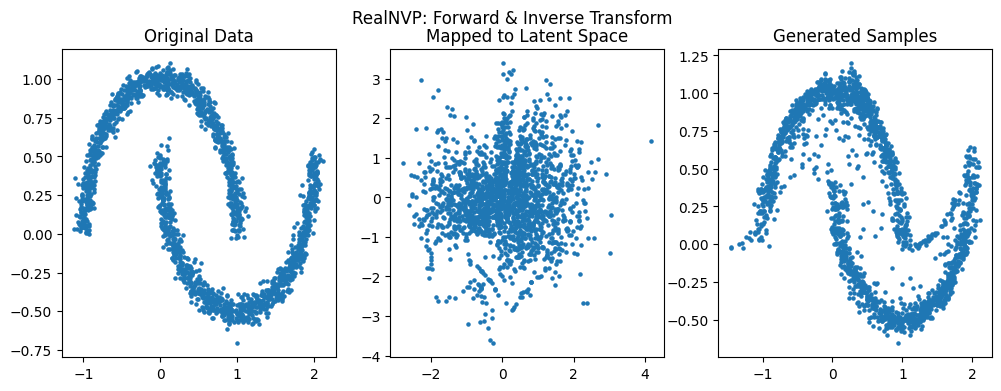

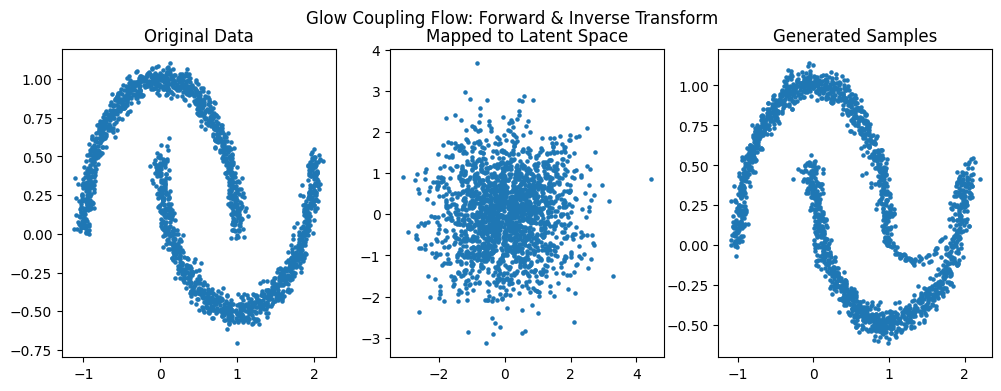

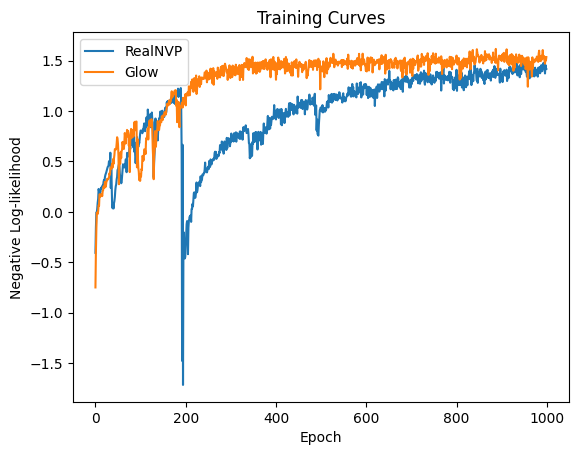

In [1]:
# ============================================================
# NORMALISING FLOWS (RealNVP + Glow) — FULL COLAB NOTEBOOK IN ONE CELL
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_swiss_roll
from sklearn.mixture import GaussianMixture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# 1. DATA GENERATION
# ============================================================

def sample_data(name="moons", n=2000):
    if name == "moons":
        x, _ = make_moons(n_samples=n, noise=0.05)
    elif name == "circles":
        x, _ = make_circles(n_samples=n, noise=0.05, factor=0.5)
    elif name == "swiss":
        x, _ = make_swiss_roll(n_samples=n, noise=0.1)
        x = x[:, [0,2]] / 10
    elif name == "gmm":
        gmm = GaussianMixture(n_components=3, covariance_type='full')
        gmm.means_ = np.array([[0,0],[3,3],[-3,3]])
        gmm.covariances_ = np.array([np.eye(2)*0.2, np.eye(2)*0.3, np.eye(2)*0.4])
        gmm.weights_ = np.array([1/3,1/3,1/3])
        gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(gmm.covariances_))
        x, _ = gmm.sample(n)
    return torch.tensor(x, dtype=torch.float32)

data = sample_data("moons").to(device)

# ============================================================
# 2. MASK CREATION
# ============================================================
def create_masks(dim=2, num_flows=6):
    masks = []
    for i in range(num_flows):
        m = torch.tensor([i % 2, (i+1) % 2], dtype=torch.float32)
        masks.append(m)
    return masks

# ============================================================
# 3. COUPLING LAYER (RealNVP or Glow affine)
# ============================================================

class CouplingLayer(nn.Module):
    def __init__(self, dim=2, hidden=128, mask=None, glow=False):
        super().__init__()
        self.mask = mask
        self.glow = glow

        self.net_s = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, dim)
        )
        self.net_t = nn.Sequential(
            nn.Linear(dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.net_s(x_masked) * (1 - self.mask)
        t = self.net_t(x_masked) * (1 - self.mask)

        if self.glow:
            y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
            logdet = torch.sum(s, dim=1)
        else:
            y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
            logdet = torch.sum(s, dim=1)

        return y, logdet

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.net_s(y_masked) * (1 - self.mask)
        t = self.net_t(y_masked) * (1 - self.mask)

        if self.glow:
            x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        else:
            x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))

        return x

# ============================================================
# 4. FULL FLOW MODEL (stack of coupling layers)
# ============================================================

class NormalisingFlow(nn.Module):
    def __init__(self, dim=2, hidden=128, num_flows=6, glow=False):
        super().__init__()
        masks = create_masks(dim, num_flows)
        self.layers = nn.ModuleList(
            [CouplingLayer(dim, hidden, mask=m, glow=glow) for m in masks]
        )

    def forward(self, x):
        logdet_sum = torch.zeros(x.size(0), device=x.device)
        for layer in self.layers:
            x, logdet = layer(x)
            logdet_sum += logdet
        return x, logdet_sum

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

# ============================================================
# 5. TRAINING ROUTINE
# ============================================================

def train_flow(flow, data, epochs=1000, lr=1e-3):
    opt = torch.optim.Adam(flow.parameters(), lr=lr)
    loglik_hist = []

    for epoch in range(epochs):
        idx = torch.randint(0, len(data), (512,))
        x = data[idx]

        z, logdet = flow(x)
        prior = -0.5 * torch.sum(z**2, dim=1)
        log_likelihood = prior + logdet

        loss = -torch.mean(log_likelihood)

        opt.zero_grad()
        loss.backward()
        opt.step()

        loglik_hist.append(-loss.item())

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Loss = {loss.item():.4f}")

    return loglik_hist

# ============================================================
# 6. TRAIN TWO FLOWS: REALNVP + GLOW
# ============================================================

realnvp = NormalisingFlow(glow=False).to(device)
glow_flow = NormalisingFlow(glow=True).to(device)

print("\nTraining RealNVP...")
realnvp_hist = train_flow(realnvp, data)

print("\nTraining Glow Coupling Flow...")
glow_hist = train_flow(glow_flow, data)

# ============================================================
# 7. VISUALISATIONS
# ============================================================

def plot_flow_results(flow, title):
    x = data[:2000].detach().cpu()
    z, _ = flow(x.to(device))
    z = z.detach().cpu()

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.scatter(x[:,0], x[:,1], s=5)
    plt.title("Original Data")

    plt.subplot(1,3,2)
    plt.scatter(z[:,0], z[:,1], s=5)
    plt.title("Mapped to Latent Space")

    z_samples = torch.randn(2000, 2).to(device)
    x_inv = flow.inverse(z_samples).detach().cpu()

    plt.subplot(1,3,3)
    plt.scatter(x_inv[:,0], x_inv[:,1], s=5)
    plt.title("Generated Samples")

    plt.suptitle(title)
    plt.show()


plot_flow_results(realnvp, "RealNVP: Forward & Inverse Transform")
plot_flow_results(glow_flow, "Glow Coupling Flow: Forward & Inverse Transform")

# Likelihood curves
plt.plot(realnvp_hist, label="RealNVP")
plt.plot(glow_hist, label="Glow")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-likelihood")
plt.title("Training Curves")
plt.legend()
plt.show()
